In [4]:
import numpy as np
import scipy.fft as fft
import scipy.optimize
import matplotlib.pyplot as plt
import pickle

In [15]:
# Setting up the signal
F_s =1e6
T = 1/F_s
f_0 = 1e5
omega_0 = 2*np.pi*f_0
phi = np.pi/8
A = 1

N = 513
n_0 = -256
t = np.arange(n_0, n_0+N)*T

SNR_db = np.arange(-10, 70, 10)
SNR_num = 10**(SNR_db/10)

ks = np.arange(10,22,2)
M = 2**ks

repetition = np.arange(200)
sample = np.arange(N)

#1a)
omega_vars = np.zeros((len(SNR_db), len(M)))
phi_vars = np.zeros((len(SNR_db), len(M)))

# for i, SNR in enumerate(SNR_num):
#     for j, m in enumerate(M):
#         temp_omega = np.zeros(100)
#         temp_phi = np.zeros(100)
#         for k in range(100):
#             noise_real = np.random.normal(0, np.sqrt(A**2/(2*SNR)), N)
#             noise_complex = np.random.normal(0, np.sqrt(A**2/(2*SNR)), N)*1j
#             signal = A*np.exp(1j*(omega_0*t+phi)) + noise_real+ noise_complex
#             F = fft.fft(signal, n=m, norm='ortho')
#             m_star = np.argmax(np.abs(F))
#             omega_hat = 2*np.pi*m_star/(m*T)
#             phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F[m_star])
#             temp_omega[k] = omega_hat- omega_0
#             temp_phi[k] = phi_hat - phi # Fixes wrapping
#         print('SNR: ', SNR_db[i], 'M: ', m, 'omega: ', np.var(temp_omega, ddof=1), 'phi: ', np.var(temp_phi, ddof=1))
#         omega_vars[i,j] = np.var(temp_omega, ddof=1)
#         phi_vars[i,j] = np.var(temp_phi, ddof=1)

t.shape
        

(513,)

In [ ]:
k_arr, snr_arr, repetition_arr, t_arr = np.meshgrid(M, SNR_num, repetition, t, indexing='ij')

signal = A*np.exp(1j*(omega_0*t_arr+phi)) + np.random.normal(0, np.sqrt(A**2/(2*snr_arr)), t_arr.shape) + 1j*np.random.normal(0, np.sqrt(A**2/(2*snr_arr)), t_arr.shape)

print(signal.shape)

temp_phi = np.zeros(signal.shape[:-1], dtype=float)
temp_omega = np.zeros(signal.shape[:-1], dtype=float)

for i, signalpack in enumerate(signal):
    F = fft.fft(signalpack, n=M[i], norm='ortho')

    m_star = np.argmax(np.abs(F), axis=-1)
    omega_hat = 2*np.pi*m_star/(M[i]*T) #dim: SNR x repetition
    
    # Get peak value of FFT
    s_idx, r_idx = np.indices(m_star.shape)
    F_peak = F[s_idx, r_idx, m_star]
    phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F_peak)
    temp_omega[i] = omega_hat - omega_0
    temp_phi[i] = phi_hat - phi # Fixes wrapping
    print(f"Done for {M[i]}")




(6, 8, 200, 513)
Done for 1024
Done for 4096
Done for 16384
Done for 65536
Done for 262144
Done for 1048576


AttributeError: module 'pickle' has no attribute 'saves'

In [11]:
with open("omega_vars.pkl", "wb") as f:
    pickle.dump(temp_omega, f)
with open("phi_vars.pkl", "wb") as f:
    pickle.dump(temp_phi, f)

In [24]:
with open("omega_vars.pkl", "rb") as f:
    temp_omega = pickle.load(f)
with open("phi_vars.pkl", "rb") as f:
    temp_phi = pickle.load(f)

var_omega = np.var(temp_omega, axis=-1, ddof=1)
var_phi = np.var(temp_phi, axis=-1, ddof=1)

var_omega.shape

(6, 8)

In [18]:
# 1b)

m = 2**10

def objective(omega, signal):
    n = np.arange(N)
    return -np.abs((1/N)*np.sum(signal*np.exp(-1j*omega*n*T)))

def F_func(omega, signal):
    n = np.arange(N)
    return (1/N)*np.sum(signal*np.exp(-1j*omega*n*T))

var_omega_NM = np.zeros(len(SNR_db))
var_phi_NM = np.zeros(len(SNR_db))

for i, SNR in enumerate(SNR_num):
    temp_omega = np.zeros(1000)
    temp_phi = np.zeros(1000)
    for k in range(1000):
        noise_real = np.random.normal(0, A**2/(2*SNR), N)
        noise_complex = np.random.normal(0, A**2/(2*SNR), N)*1j
        signal = A*np.exp(1j*(omega_0*t+phi)) + noise_real+ noise_complex
        F = fft.fft(signal, n=m, norm='ortho')
        m_star = np.argmax(np.abs(F))
        omega_hat = 2*np.pi*m_star/(m*T)
        phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F[m_star])
        res = scipy.optimize.minimize(objective, omega_hat, args=( signal),method='Nelder-Mead')
        omega_hat_new = res.x[0]
        phi_hat_new = np.angle(np.exp(-1j*omega_hat_new*n_0*T)*F_func(omega_hat_new, signal))
        temp_omega[k] = omega_hat_new - omega_0
        temp_phi[k] = phi_hat_new - phi
    var_omega_NM[i] = np.var(temp_omega, ddof=1)
    var_phi_NM[i] = np.var(temp_phi, ddof=1)
    
        

In [19]:
var_omega_NM

array([1.98022552e+12, 2.17037215e+04, 2.15849400e+02, 2.27394567e+00,
       2.31229618e-02, 2.34944692e-04, 2.27600213e-06, 2.35331886e-08])

Text(0.5, 9.444444444444104, '$\\log_2(M)$')

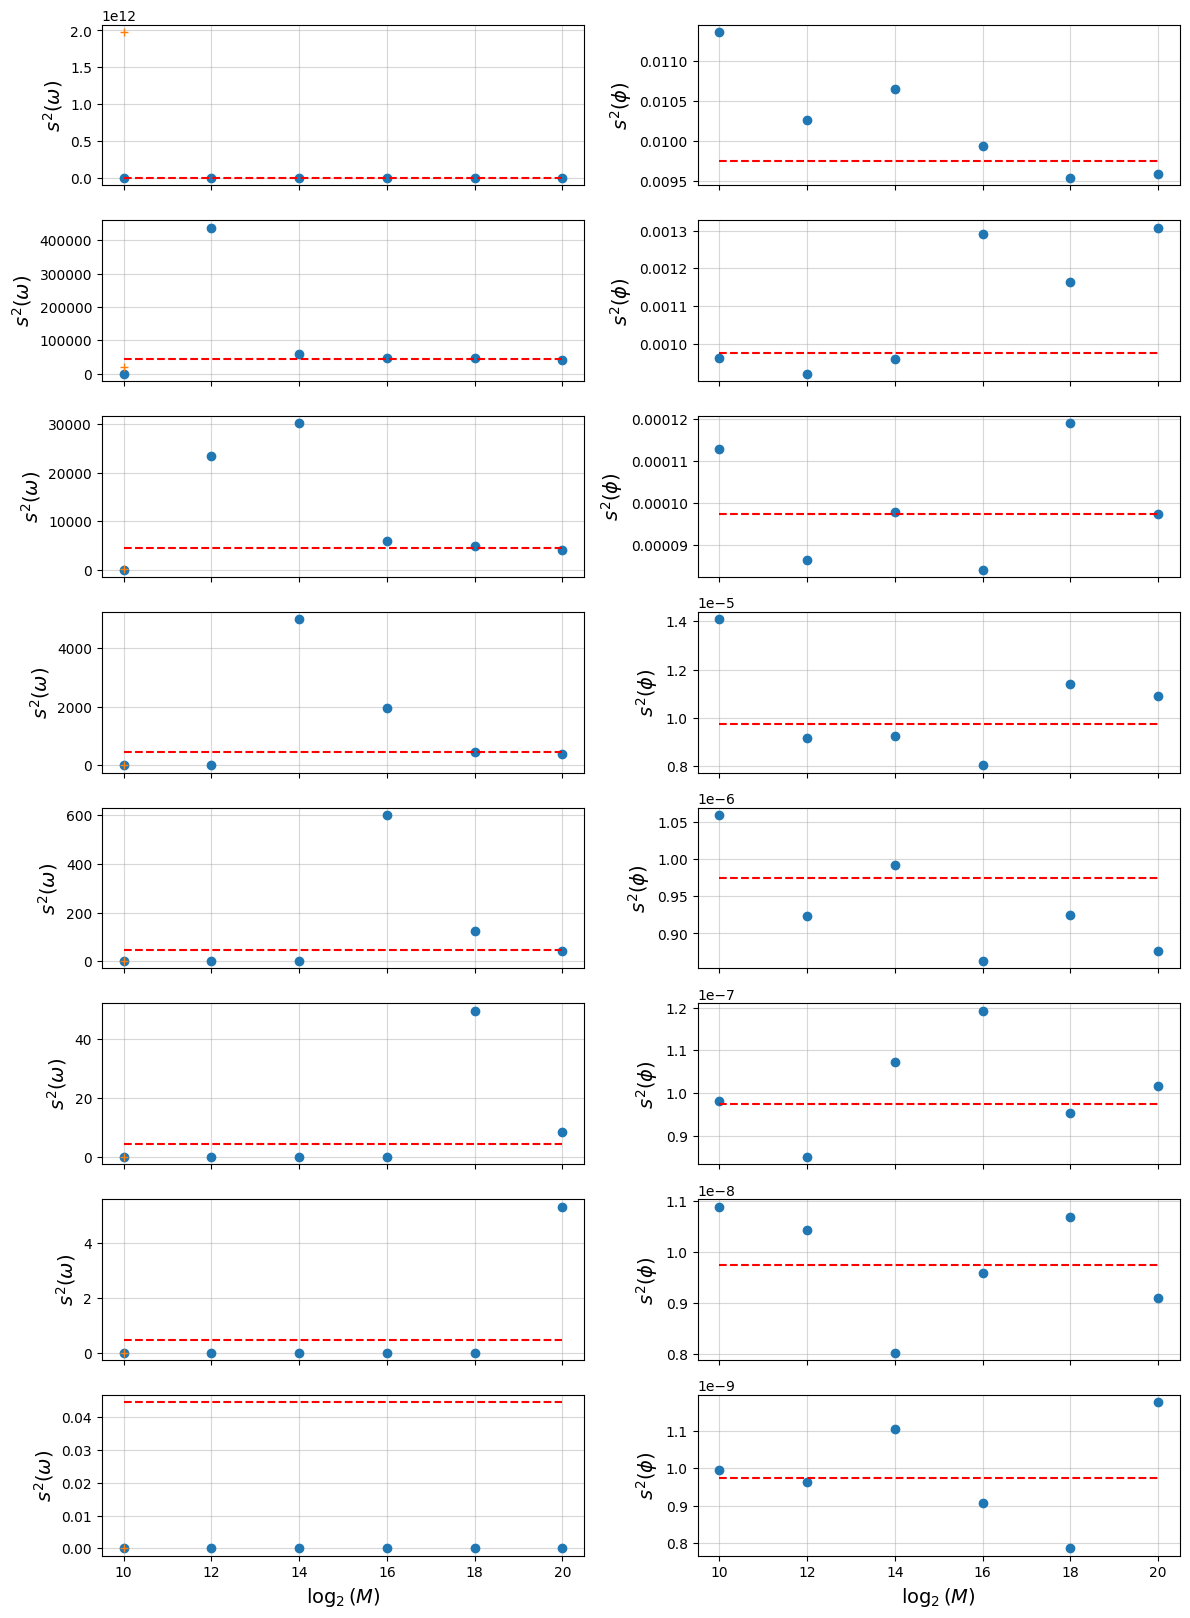

In [ ]:
#Plotting
crlb_omega = 12*(1/(2*SNR_num))/(T**2*N*(N+1)*(N-1))

P = N*(N-1)/2
Q = N*(N-1)*(2*N-1)/6

crlb_phi = (12*(1/(2*SNR_num))*(n_0**2*N+2*n_0*P+Q))/(N**2*(N-1)*(N+1))

fig, ax = plt.subplots(len(SNR_db), 2, figsize=(12, 16), sharex=True)
for i, db in enumerate(SNR_db):
    fig.tight_layout()
    ax[i, 0].plot(ks, var_omega[:,i], 'o')
    ax[i,0].plot(10, var_omega_NM[i], '+')
    ax[i, 0].plot(ks, crlb_omega[i]*np.ones(len(ks)), 'r--')
    ax[i, 0].set_ylabel('$s^2(\omega)$', fontsize=14)
    ax[i, 0].grid(alpha=0.5)
    ax[i, 1].plot(ks, var_phi[:,i], 'o')
    ax[i, 1].plot(ks, crlb_phi[i]*np.ones(len(ks)), 'r--')
    ax[i, 1].set_ylabel('$s^2(\phi)$', fontsize=14)
    ax[i, 1].grid(alpha=0.5)
ax[-1,0].set_xlabel('$\log_2(M)$', fontsize=14)
ax[-1,1].set_xlabel('$\log_2(M)$', fontsize=14)